In [3]:
from yf import yf_download

yf_download(['QQQ','DXY','ZQ=F','GSG','CL=F'])

skipping qqq
skipping dxy


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['fundamental/zq=f-2025-11-17.parquet',
 'fundamental/gsg-2025-11-17.parquet',
 'fundamental/cl=f-2025-11-17.parquet']

In [4]:
import pandas as pd
import numpy as np
from glob import glob
import re
from os.path import basename

df = pd.DataFrame()

files = glob('pd-data/*.parquet')[:10]
coins = list(map(lambda f: re.search(r'(.+)\.parquet', basename(f)).group(1), files))
coins = ['btc','eth','ada']

for tick in coins:
    df2 = pd.read_parquet(f'pd-data/{tick}.parquet')
    df = df2.reset_index() \
       .set_index('timestamp') \
       .drop(columns=['asset']) \
       .rename(columns={
           'price':f'{tick}_close',
           'total_volume':f'{tick}_volume'
       }) \
       .drop(columns=[c for c in df2.columns if c not in set(['price','total_volume'])]) \
       .join(df, how='outer')

vol_cols = [f'{c}_volume' for c in coins]
close_cols = [f'{c}_close' for c in coins]
logret_cols = [f'{c}_logret' for c in coins]
relvol_cols = [f'{c}_relvol' for c in coins]

df[logret_cols] = np.log(df[close_cols] / df[close_cols].shift(1))

lb_cols = {}
for lb in [1,7,14]:
    lb_cols[lb] = [f'{c}_{lb}d' for c in coins] 
    df[lb_cols[lb]] = df[logret_cols].rolling(lb).sum()

df['total_volume'] = df[vol_cols].sum(axis=1)
for c in coins:
    df[f'{c}_relvol'] = df[f'{c}_volume'] / df.total_volume

for i in range(0, len(df)):
    ts = df.index[i]
    row = df.loc[ts]
    for lb in [1,7,14]:
        cols = lb_cols[lb]
        winners = row[cols].mask(row[cols] <= 0).dropna()
        wcols = [c.split('_')[0] for c in winners.index.to_list()]
        df.loc[ts, f'return_{lb}d'] = \
            np.sum(row[[f'{c}_relvol' for c in wcols]].values * row[[f'{c}_logret' for c in wcols]].values)
    

# XXX: investigate signal
# all coins
# short

df[['return_1d','return_7d','return_14d','btc_logret']].groupby(df.index.year).sum()

# retrieve data
# compute indicators
# for each step
    # defined portfolio weights
    # compute tracking error
    # evaluate risk
    # execute trades
    # update metrics
# show results

,return_1d,return_7d,return_14d,btc_logret
timestamp,,,,
2010,2.624445,0.695430,-0.239305,0.735620
2011,12.038410,6.362020,4.919954,2.798297
2012,4.965019,2.103445,1.976173,1.227799
2013,10.714279,5.742498,4.346963,4.006697
2014,4.472889,1.262536,0.675131,-0.830194
2015,4.490799,1.796793,1.263661,0.286021
2016,3.434946,1.443666,1.233327,0.816223
2017,9.758569,5.584700,5.009107,2.661077
2018,5.834652,1.896954,0.996947,-1.324785


/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_38155/4126874621.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  long = bullish | bullish.shift(-1).fillna(False)
/var/folders/tl/9yq9dyyj1sl6tn4r875nj5ym0000gn/T/ipykernel_38155/4126874621.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  short = (~bullish) | (~bullish).shift(-1).fillna(False)


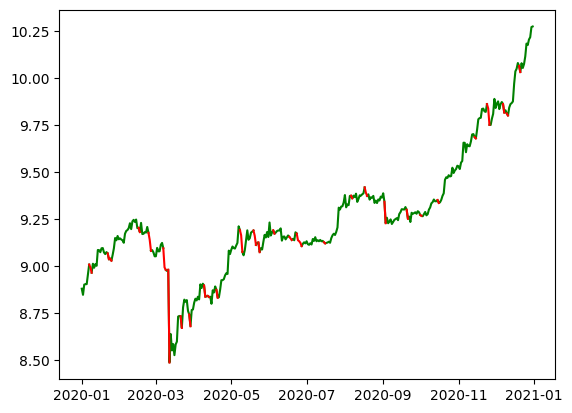

In [149]:
from matplotlib import pyplot as plt

ss = df.loc['2020']
close = np.log(ss.btc_close)
bullish = ss.return_1d > 0.0

# make sure transition points overlap for plotting
long = bullish | bullish.shift(-1).fillna(False)
short = (~bullish) | (~bullish).shift(-1).fillna(False)

plt.plot(close.mask(~long),color='green',label='long')
plt.plot(close.mask(~short),color='red',label='short')

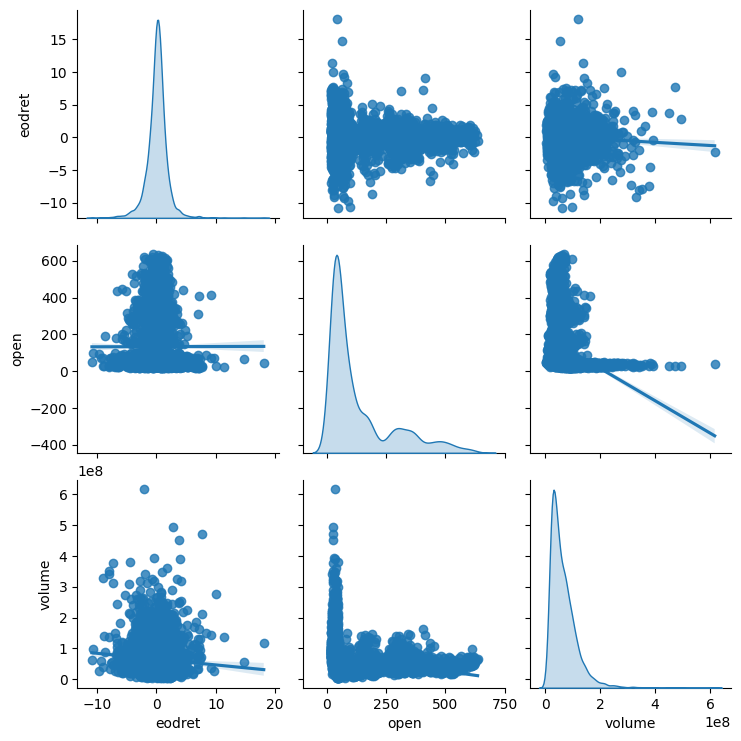

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

qqq = pd.read_parquet('fundamental/qqq-2025-11-14.parquet')
qqq.drop(columns=['close','high','low'],inplace=True)
dxy = pd.read_parquet('fundamental/dxz-2025-11-14.parquet')
zq = pd.read_parquet('fundamental/zq-2025-11-14.parquet')
gsg = pd.read_parquet('fundamental/gsg-2025-11-14.parquet')
cl = pd.read_parquet('fundamental/cl=f-2025-11-14.parquet')

y = (((X.open / X.shift(1).open) - 1) * 100).shift(-1).fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

df = X_train.copy()
df.insert(0, "eodret", y_train)
sns.pairplot(df, kind="reg", diag_kind="kde")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2005-09-19 to 2010-01-19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   eodret  5035 non-null   float64
 1   open    5035 non-null   float64
 2   volume  5035 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 157.3 KB
